<a href="https://colab.research.google.com/github/bhargav23/EVA4/blob/master/S7/EVA_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



plane   dog  deer  deer


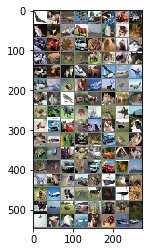

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
from tqdm import tqdm_notebook, tnrange
import torch.nn.functional as F
import torch

dropout_value = 0.07
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
          nn.Conv2d(3, 32, 3,padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
          nn.Conv2d(32, 32, 3,padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Dropout(dropout_value)
        )

        self.convblock3 = nn.Sequential(
          nn.Conv2d(32, 32, 3,padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Dropout(dropout_value)      
        )

        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
	      nn.Conv2d(32, 64, 3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(dropout_value)
        )

        self.convblock5 = nn.Sequential(
        nn.Conv2d(64, 64, 3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(dropout_value)
        )

     

        self.pool2 = nn.MaxPool2d(2, 2)

        self.dconvblock1 = nn.Sequential(
	      nn.Conv2d(64, 128, 3,dilation=2,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
        nn.Conv2d(64, 128, 3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
        nn.Conv2d(128, 128, 3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Dropout(dropout_value)      
        )

        self.pool3 = nn.MaxPool2d(2, 2)

        self.convblock8 = nn.Sequential(
        nn.Conv2d(128, 128, 3,groups=128,dilation=1,padding=1),
        nn.Conv2d(128, 256, kernel_size=(1,1))
        
        
          
        )

        self.convblock9 = nn.Sequential(
        nn.Conv2d(256, 256, 3,groups=256,dilation=1,padding=1),
        nn.Conv2d(256, 256, kernel_size=(1,1)),
           
        )


        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=(4,4))
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) 




    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x1 = self.dconvblock1(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = torch.add(x, x1)

        x = self.pool3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)        
        x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
        MaxPool2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1

In [0]:
test_loss_l1=[]
test_acc_l1=[]
test_loss_l2=[]
test_acc_l2=[]
test_loss_both=[]
test_acc_both=[]
test_loss_none=[]
test_acc_none=[]

In [0]:
import copy

In [0]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

misclassified=[]
lambda1 = 0.0002
lambda2 = 0.0001
def train(model, device, train_loader, optimizer, epoch, reg):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #loss += lambda1*torch.norm(model.parameters(),1)
    #model_params = torch.cat([x.view(-1) for x in model.parameters()])
    #loss += lambda1*torch.norm(model_params,1)
    # regularization_loss = 0
    # for param in model.parameters():
    #   regularization_loss += torch.sum(torch.abs(param))
    # loss += lambda1*regularization_loss
    regularization_loss1 = 0
    regularization_loss2 = 0

    # for param in model.parameters():
    #   regularization_loss1 += torch.norm(param,1)
    #   regularization_loss2 += torch.norm(param,2)
    # loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
    if reg=="None":
      train_losses.append(loss)
    elif reg=="L1":
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
      #regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1)
      train_losses.append(loss)
    elif reg=="L2":
      for param in model.parameters():
        #regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda2*regularization_loss2)
      train_losses.append(loss)
    else:
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
      train_losses.append(loss)




    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, reg):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            temp = pred.eq(target.view_as(pred)).sum().item()
            temp1 = target.view_as(pred)
            if(len(misclassified)<25):
              for i in range(len(temp1)):
                if(temp1[i]!=pred[i]):
                  misclassified.append([data[i],temp1[i],pred[i]])
                if(len(misclassified)==25):
                  break
            correct += temp


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,"L2")
    # scheduler.step()
    test(model, device, testloader,"L2")
test_loss_l2 = copy.deepcopy(test_losses)
test_acc_l2 = copy.deepcopy(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.0608283281326294 Batch_id=390 Accuracy=42.51: 100%|██████████| 391/391 [00:15<00:00, 24.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1776, Accuracy: 5696/10000 (56.96%)

EPOCH: 1


Loss=1.0006107091903687 Batch_id=390 Accuracy=66.25: 100%|██████████| 391/391 [00:15<00:00, 24.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8454, Accuracy: 7023/10000 (70.23%)

EPOCH: 2


Loss=0.5839313864707947 Batch_id=390 Accuracy=74.71: 100%|██████████| 391/391 [00:15<00:00, 28.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6968, Accuracy: 7518/10000 (75.18%)

EPOCH: 3


Loss=0.876641571521759 Batch_id=390 Accuracy=79.00: 100%|██████████| 391/391 [00:15<00:00, 24.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6479, Accuracy: 7728/10000 (77.28%)

EPOCH: 4


Loss=0.6742877960205078 Batch_id=390 Accuracy=81.72: 100%|██████████| 391/391 [00:15<00:00, 24.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6852, Accuracy: 7699/10000 (76.99%)

EPOCH: 5


Loss=0.3374074399471283 Batch_id=390 Accuracy=84.14: 100%|██████████| 391/391 [00:15<00:00, 24.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5992, Accuracy: 7957/10000 (79.57%)

EPOCH: 6


Loss=0.46614325046539307 Batch_id=390 Accuracy=86.07: 100%|██████████| 391/391 [00:15<00:00, 24.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5351, Accuracy: 8200/10000 (82.00%)

EPOCH: 7


Loss=0.41041111946105957 Batch_id=390 Accuracy=87.56: 100%|██████████| 391/391 [00:15<00:00, 24.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5855, Accuracy: 8133/10000 (81.33%)

EPOCH: 8


Loss=0.4118618369102478 Batch_id=390 Accuracy=88.84: 100%|██████████| 391/391 [00:16<00:00, 24.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5522, Accuracy: 8269/10000 (82.69%)

EPOCH: 9


Loss=0.4669828712940216 Batch_id=390 Accuracy=90.01: 100%|██████████| 391/391 [00:15<00:00, 24.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6229, Accuracy: 8086/10000 (80.86%)

EPOCH: 10


Loss=0.31500422954559326 Batch_id=390 Accuracy=91.26: 100%|██████████| 391/391 [00:15<00:00, 25.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6004, Accuracy: 8184/10000 (81.84%)

EPOCH: 11


Loss=0.2240392416715622 Batch_id=390 Accuracy=92.17: 100%|██████████| 391/391 [00:15<00:00, 28.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6189, Accuracy: 8210/10000 (82.10%)

EPOCH: 12


Loss=0.30503973364830017 Batch_id=390 Accuracy=92.88: 100%|██████████| 391/391 [00:15<00:00, 24.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5972, Accuracy: 8307/10000 (83.07%)

EPOCH: 13


Loss=0.15426330268383026 Batch_id=390 Accuracy=93.73: 100%|██████████| 391/391 [00:15<00:00, 25.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6129, Accuracy: 8312/10000 (83.12%)

EPOCH: 14


Loss=0.16088926792144775 Batch_id=390 Accuracy=94.33: 100%|██████████| 391/391 [00:15<00:00, 25.39it/s]



Test set: Average loss: 0.6456, Accuracy: 8289/10000 (82.89%)



GroundTruth:  plane  bird   car plane


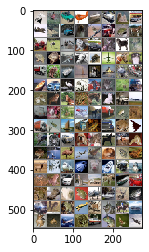

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  horse  bird  bird horse


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 8 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  6 %
Accuracy of   car :  0 %
Accuracy of  bird : 48 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  2 %
Accuracy of horse : 11 %
Accuracy of  ship :  0 %
Accuracy of truck : 17 %
